# Package Installation
```python3
# conda update --all 
# conda create -n control-env-3-10 pytest numpy scipy control matplotlib ipykernel slycot pandas python=3.10
```

## Importing Libraries


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import pandas as pd
from numpy.fft import fft
from scipy.signal.windows import hann

## Define Functions

In [65]:
def get_leadlag1(fZero, fPole, Ts):

    alpha = fZero / fPole
    fCenter = fPole * np.sqrt(alpha)
    phaseLift = np.arcsin((1.0 - alpha) / (1.0 + alpha)) * (180.0 / np.pi)

    return get_phase_comp(fCenter, phaseLift, Ts)


def get_leadlag2(fZero, DZero, fPole, DPole, Ts):

    wZero = 2 * np.pi * fZero
    wPole = 2 * np.pi * fPole

    wZero = 2 / Ts * np.tan(wZero * Ts / 2)
    wPole = 2 / Ts * np.tan(wPole * Ts / 2)

    k0 = wPole * wPole
    k1 = wZero * wZero
    k2 = Ts * Ts * k0 * k1
    k3 = DPole * Ts * wPole * k1
    k4 = DZero * Ts * k0 * wZero
    k5 = 1 / (k2 + 4 * (k1 + k3))

    b0 = (k2 + 4 * (k4 + k0)) * k5
    b1 = 2 * (k2 - 4 * k0) * k5
    b2 = (k2 + 4 * (k0 - k4)) * k5
    a1 = 2 * (k2 - 4 * k1) * k5
    a2 = (k2 + 4 * (k1 - k3)) * k5

    B = [b0, b1, b2]
    A = [1, a1, a2]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_lowpass1(fcut, Ts):

    a1 = -np.exp(-Ts * 2 * np.pi * fcut)
    b0 = 1 + a1

    B = [b0, 0]
    A = [1, a1]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_lowpass2(fcut, D, Ts):

    wcut = 2 * np.pi * fcut
    k1 = 2 * D * Ts * wcut

    a2 = 1 / (Ts**2 * wcut**2 + k1 + 1)
    a1 = -(k1 + 2) * a2
    b0 = 1 + a1 + a2

    B = [b0, 0, 0]
    A = [1, a1, a2]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_notch(fcut, D, Ts):

    Q = 1 / (2 * D)
    #  prewarp is done implicitly
    omega = 2 * np.pi * fcut * Ts
    sn = np.sin(omega)
    cs = np.cos(omega)
    alpha = sn / (2 * Q)

    b0 = 1 / (1 + alpha)
    b1 = -2 * cs / (1 + alpha)
    b2 = b0
    a1 = b1
    a2 = (1 - alpha) / (1 + alpha)

    B = [b0, b1, b2]
    A = [1, a1, a2]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_phase_comp(fCenter, phaseLift, Ts):

    omega = 2.0 * np.pi * fCenter * Ts
    sn = np.sin(phaseLift * np.pi / 180)
    gain = (1 + sn) / (1 - sn)
    # approximate prewarping (series expansion)
    alpha = (12 - omega**2) / (6 * omega * np.sqrt(gain))
    k = 1.0 / (1.0 + alpha)

    b0 = (1 + alpha * gain) * k
    b1 = (1 - alpha * gain) * k
    a1 = (1 - alpha) * k

    B = [b0, b1]
    A = [1, a1]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


# @dataclass
class Data:

    def __init__(self, file_name):
        self.__data = pd.read_csv(file_name, header=None)

    def time(self):
        return self.__data.iloc[:, 0]

    def values(self, indices):
        return self.__data.iloc[:, indices]


def calc_freqresp_and_cohere(P, delta):

    P[:, 0] = P[:, 0] + delta
    g = P[:, 1] / P[:, 0]
    c = np.abs(P[:, 1]) ** 2 / (P[:, 0] * P[:, 2])

    return g, c


def estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts, delta=0.0):

    inp = inp - np.mean(inp)
    out = out - np.mean(out)

    Ndata = len(inp)

    # Factor 2 for single-sided spectrum
    W = np.sum(window) / Nest / 2

    Pavg = np.zeros((Nest, 3), dtype=np.complex128)
    Navg = 0
    ind_start = 0
    ind_end = Nest
    Ndelta = Nest - Noverlap

    while ind_end <= Ndata:
        ind = slice(ind_start, ind_end)

        inp_act = inp[ind]
        out_act = out[ind]

        # Remove mean
        inp_act = inp_act - np.mean(inp_act)
        out_act = out_act - np.mean(out_act)

        inp_act = window * inp_act
        out_act = window * out_act

        U = fft(inp_act) / (Nest * W)
        Y = fft(out_act) / (Nest * W)

        Pavg += np.vstack((U * np.conj(U), Y * np.conj(U), Y * np.conj(Y))).T
        Navg += 1

        ind_start += Ndelta
        ind_end += Ndelta

    Pavg /= Navg

    g, c = calc_freqresp_and_cohere(Pavg, 0.0)
    df = 1 / (Nest * Ts)
    freq = np.arange(0, 1 / Ts, df)

    # Create the FRD (Frequency Response Data) objects
    G = ct.frd(g, freq)
    C = ct.frd(c, freq)

    return G, C, freq, Pavg


def plot_exc(data, indices):

    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    axs[0].plot(data.time(), data.values(indices["exc"]))
    axs[0].grid(True)
    axs[0].set_ylabel("exc")
    axs[1].plot(data.time(), data.values(indices["sinarg"]))
    axs[1].grid(True)
    axs[1].set_ylabel("sinarg (rad)")
    axs[2].plot(data.time(), data.values(indices["freq"]))
    axs[2].grid(True)
    axs[2].set_ylabel("fchirp (Hz)")
    axs[2].set_xlabel("Time (sec)")
    plt.show()


def plot_bode_compare(G, Gest, Cest, freq, Ts):

    condition = (0 < freq) & (freq < 1 / (2.0 * Ts))
    Gest = Gest.fresp.flatten()
    Gest = Gest[condition]
    Cest = Cest.fresp.flatten()
    Cest = Cest[condition]
    freq = freq[condition]

    mag, phase, _ = G.frequency_response(2.0 * np.pi * freq)

    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    axs[0].semilogx(freq, 20 * np.log10(np.abs(Gest)))
    axs[0].semilogx(freq, 20 * np.log10(mag))
    axs[0].grid(True)
    axs[0].set_ylabel("Magnitude (dB)")
    axs[1].semilogx(freq, np.angle(Gest, deg=True))
    axs[1].semilogx(freq, phase * (180.0 / np.pi))
    axs[1].grid(True)
    axs[1].set_ylabel("Phase (deg)")
    axs[2].semilogx(freq, 20 * np.log10(np.abs(Cest)))
    axs[2].grid(True)
    axs[2].set_ylabel("Coherence")
    axs[2].set_xlabel("Frequency (Hz)")
    plt.show()


def plot_signal(data, indices, signal):

    plt.figure(figsize=(10, 6))
    plt.plot(data.time(), data.values(indices[signal]))
    plt.grid(True)
    plt.ylabel(signal)
    plt.xlabel("Time (sec)")
    plt.show()

## Load Data

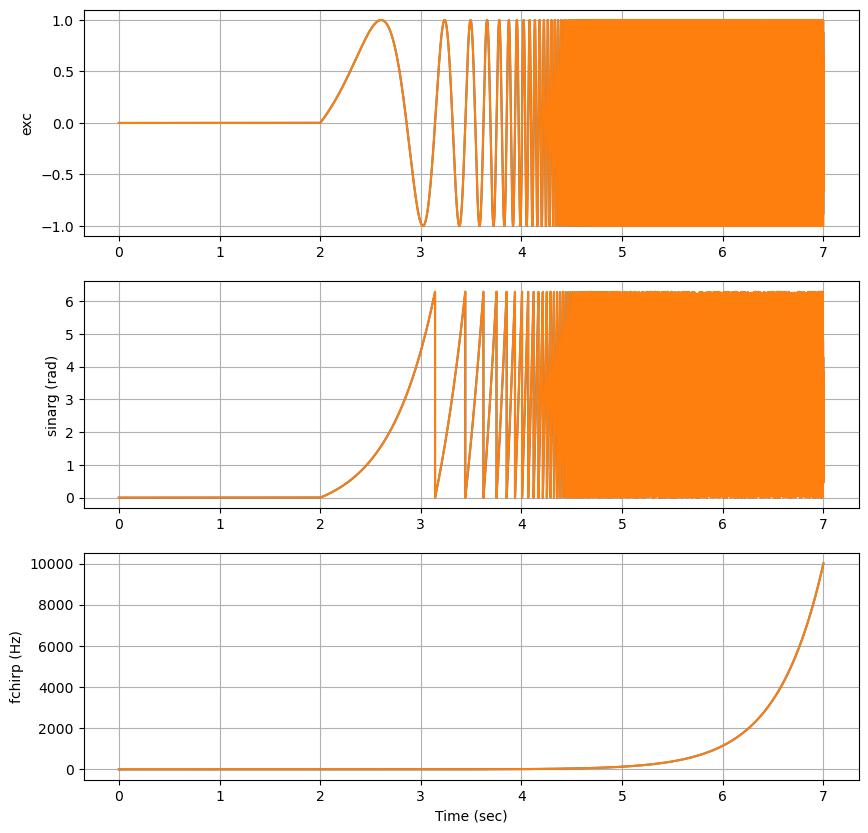

In [66]:
data = Data("../../output/data.txt")

Ts = np.floor(np.mean(np.diff(data.time())) * 1e6) * 1e-6

indices = {
    "exc": [1, 4],
    "freq": [2, 5],
    "sinarg": [3, 6],
    "notch": [7, 8],
    "lp2": [9, 10],
    "lp1": [11, 12],
    "ll1": [13, 14],
    "pc1": [15, 16],
    "ll2": [17, 18],
}

# frequency response estimation
Nest = round(1.0 / Ts)
koverlap = 0.9
Noverlap = round(koverlap * Nest)
window = hann(Nest)

plot_exc(data, indices)

## Evaluate different Filters

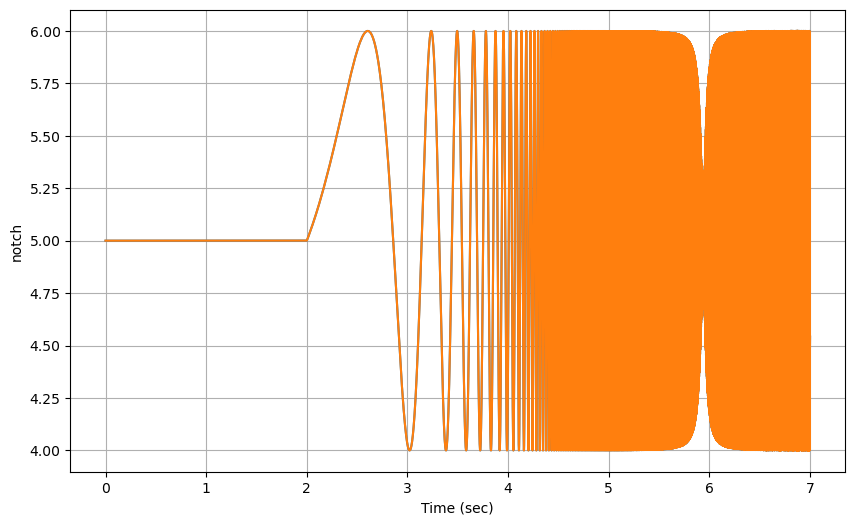

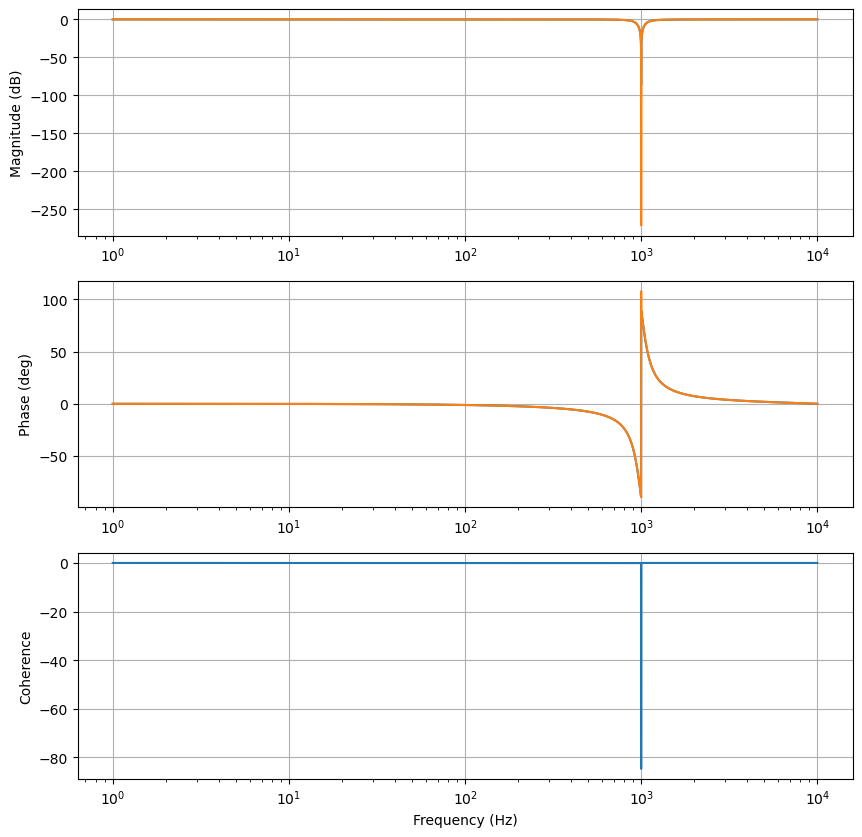

In [67]:
# define NOTCH_F_CUT 1.0e3f
# define NOTCH_D 0.1f
fn = 1.0e3
Dn = 0.1
sig = "notch"

plot_signal(data, indices, sig)

inp = data.values(indices["exc"][0])
out = data.values(indices[sig][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

plot_bode_compare(get_notch(fn, Dn, Ts), Gest, Cest, freq, Ts)

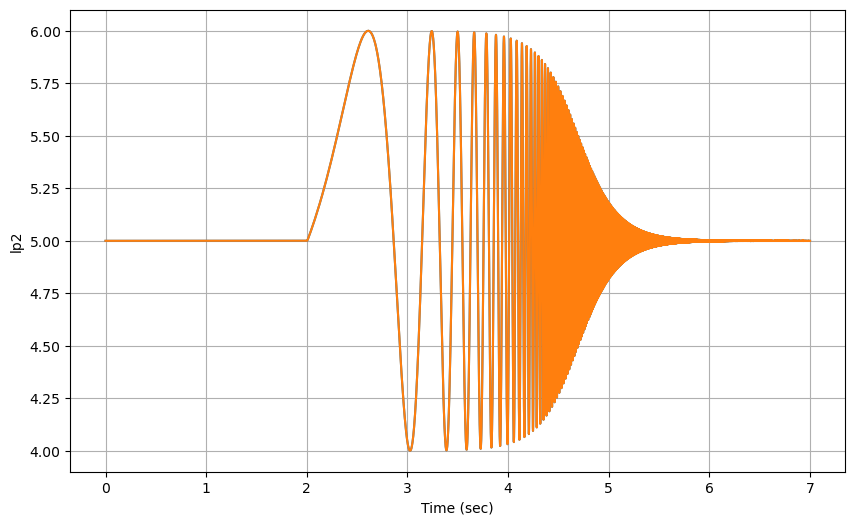

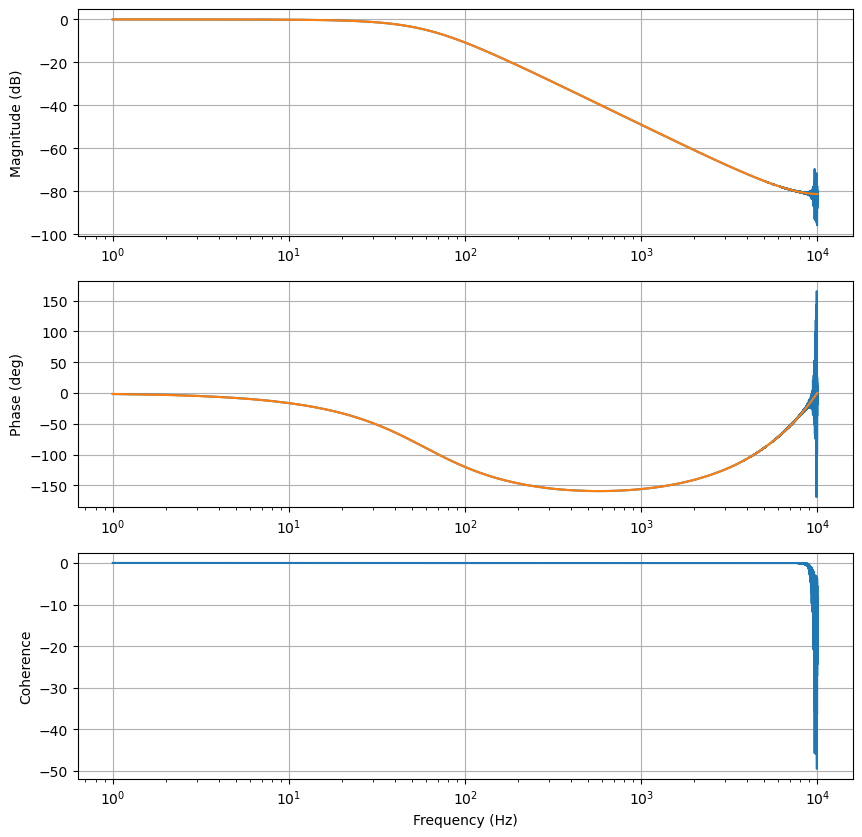

In [68]:
# define LOWPASS2_F_CUT 60.0f
# define LOWPASS2_D (sqrtf(3.0f) / 2.0f)
flp2 = 60.0
Dlp2 = np.sqrt(3.0) / 2.0
sig = "lp2"

plot_signal(data, indices, sig)

inp = data.values(indices["exc"][0])
out = data.values(indices[sig][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

plot_bode_compare(get_lowpass2(flp2, Dlp2, Ts), Gest, Cest, freq, Ts)

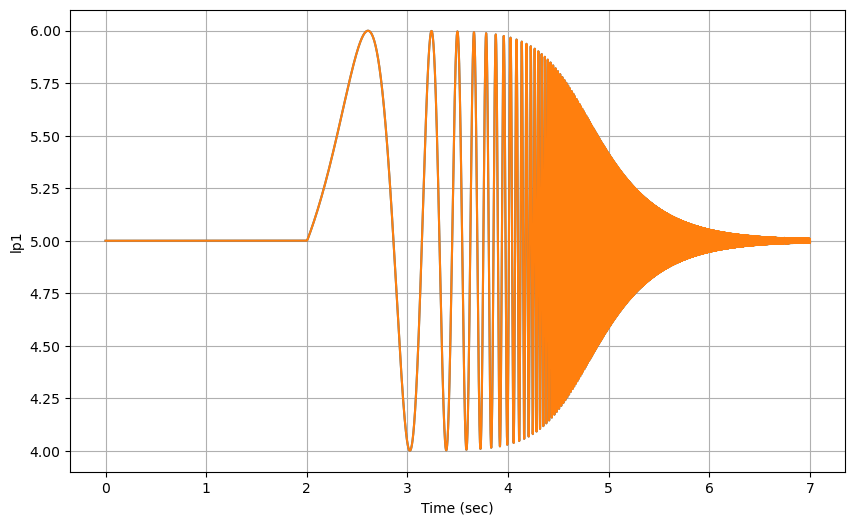

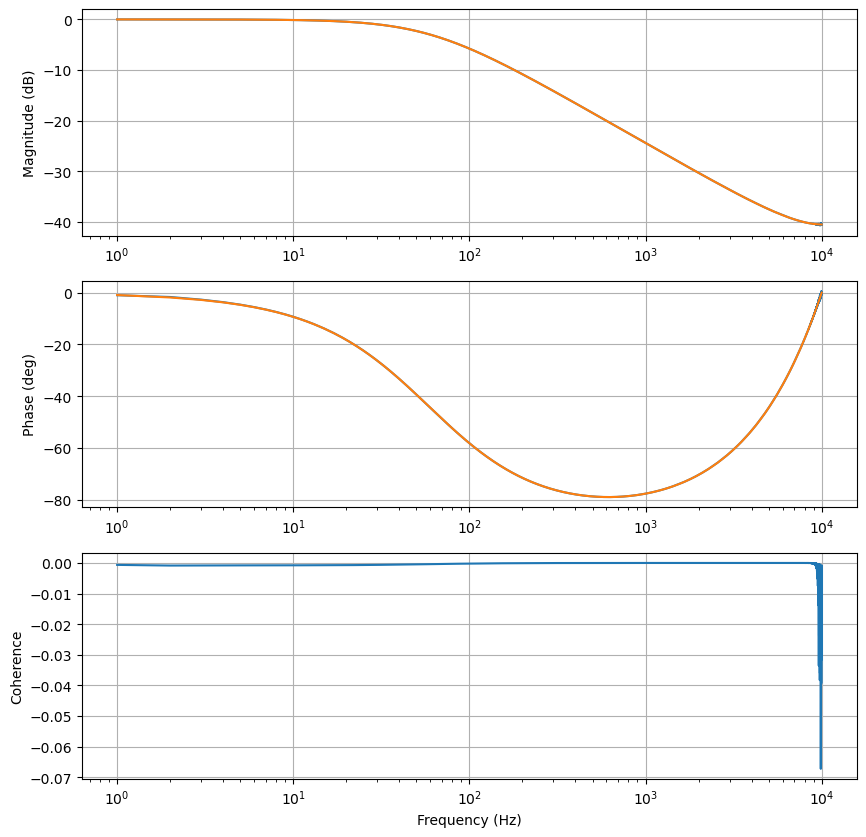

In [69]:
# define LOWPASS1_F_CUT 60.0f
flp1 = 60.0
sig = "lp1"

plot_signal(data, indices, sig)

inp = data.values(indices["exc"][0])
out = data.values(indices[sig][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

plot_bode_compare(get_lowpass1(flp1, Ts), Gest, Cest, freq, Ts)

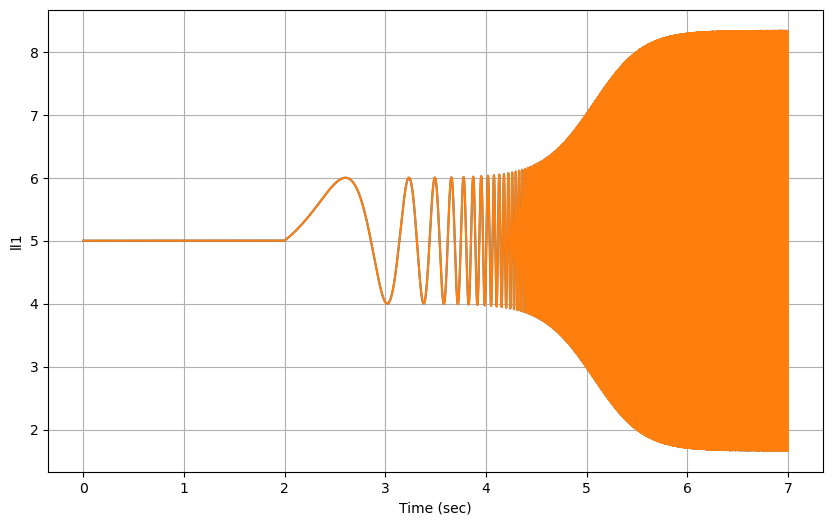

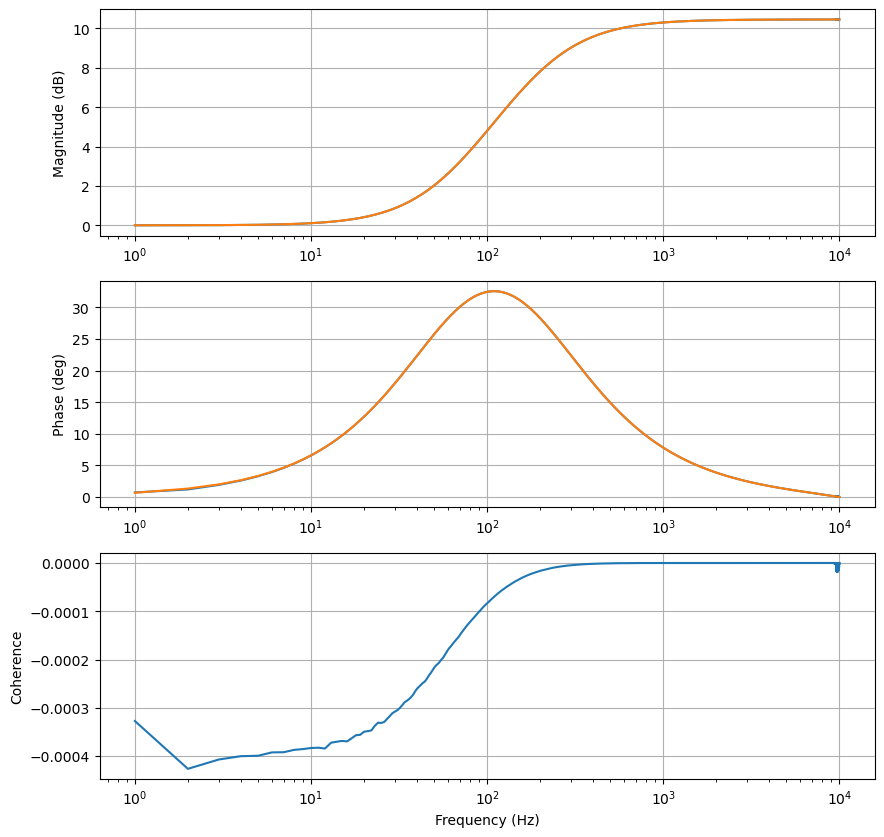

In [70]:
# define LEADLAG1_F_ZERO 60.0f
# define LEADLAG1_F_POLE 200.0f
fz1 = 60.0
fp1 = 200.0
sig = "ll1"

plot_signal(data, indices, sig)

inp = data.values(indices["exc"][0])
out = data.values(indices[sig][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

plot_bode_compare(get_leadlag1(fz1, fp1, Ts), Gest, Cest, freq, Ts)

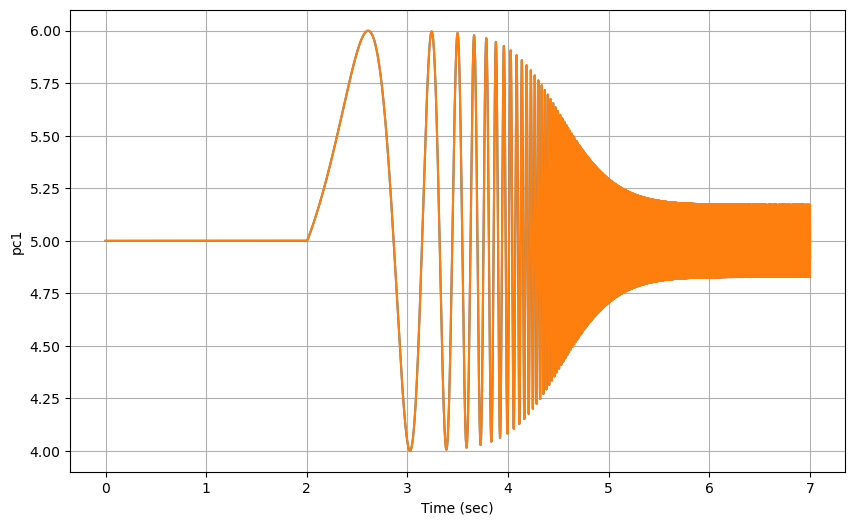

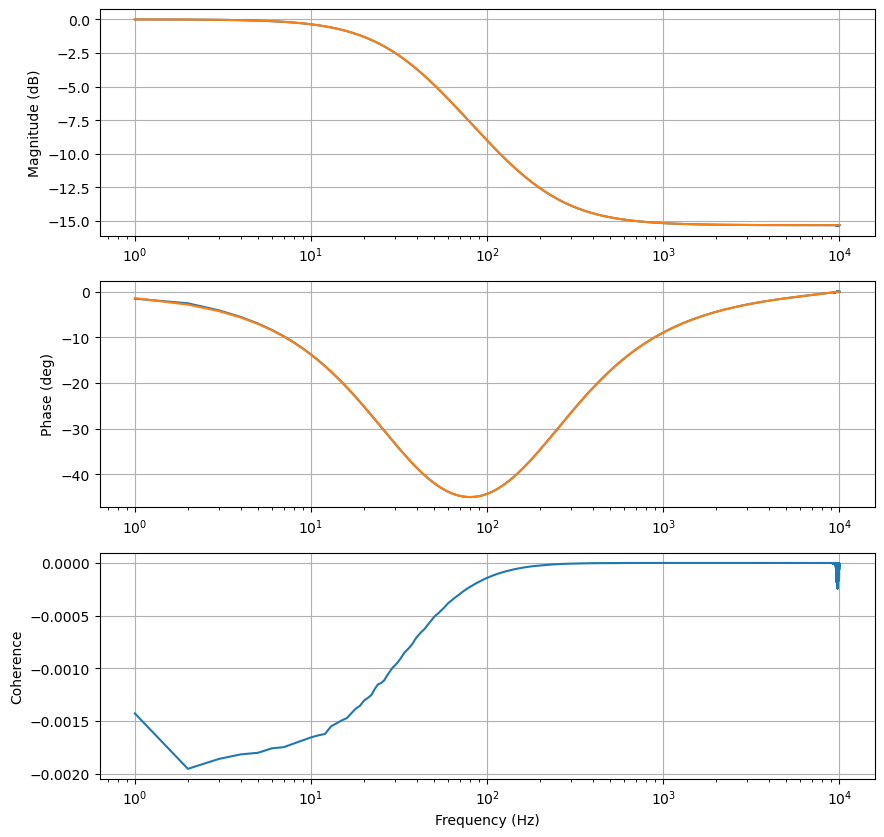

In [71]:
# define PHASECOMP1_F_CENTER 80.0f
# define PHASECOMP1_PHASE_LIFT -45.0f
fc1 = 80.0
phal1 = -45.0
sig = "pc1"

plot_signal(data, indices, sig)

inp = data.values(indices["exc"][0])
out = data.values(indices[sig][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

plot_bode_compare(get_phase_comp(fc1, phal1, Ts), Gest, Cest, freq, Ts)

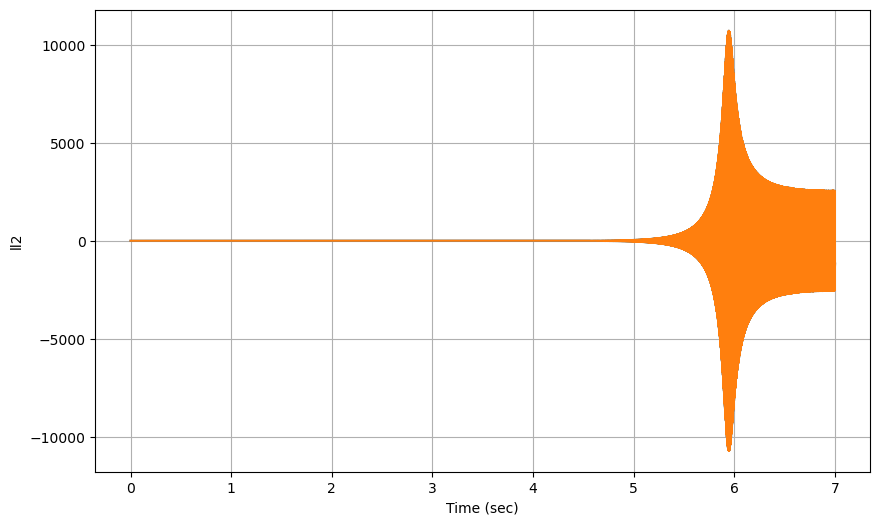

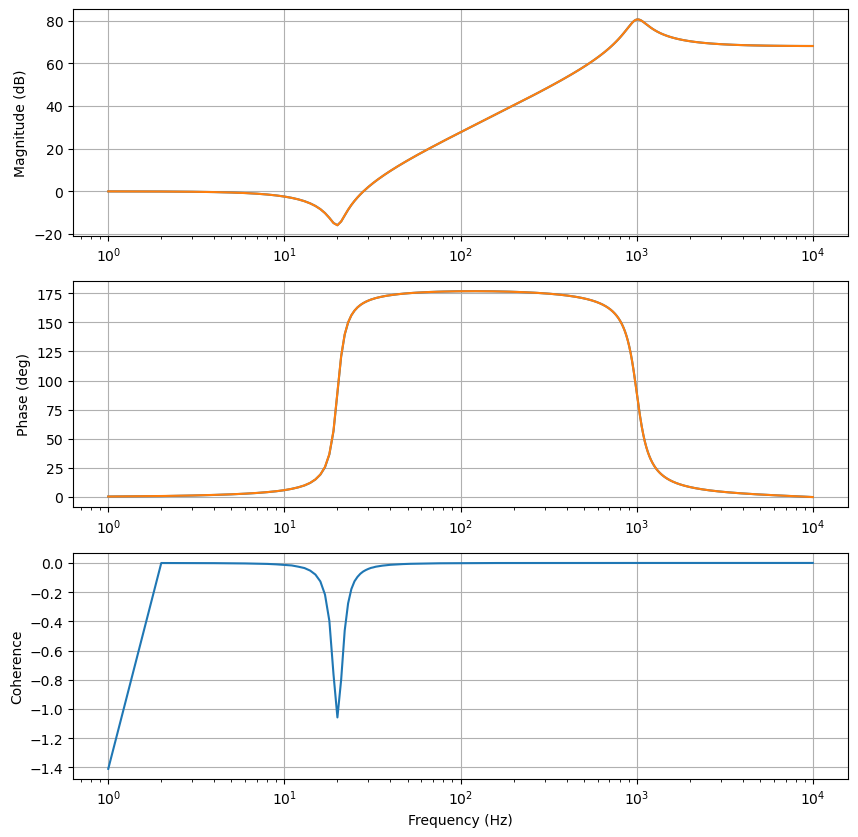

In [72]:
# define LEADLAG2_F_ZERO 20.0f
# define LEADLAG2_D_ZERO 0.08f
# define LEADLAG2_F_POLE 1000.0f
# define LEADLAG2_D_POLE 0.12f
fzll2 = 20.0
Dzll2 = 0.08
fpll2 = 1000.0
Dpll2 = 0.12
sig = "ll2"

plot_signal(data, indices, sig)

inp = data.values(indices["exc"][0])
out = data.values(indices[sig][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

plot_bode_compare(get_leadlag2(fzll2, Dzll2, fpll2, Dpll2, Ts), Gest, Cest, freq, Ts)